# Lab 7 Word Sequences

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

## Imports

In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.metrics.distance import jaccard_distance
from scipy.stats import pearsonr
import spacy

### Might need to run:
```
!pip install spacy
!python3 -m spacy download en_core_web_sm

In [2]:
!pip install spacy
!python3 -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.7 MB/s  0:00:00a 0:00:0136m0:00:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Load Data

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')

nlp = spacy.load("en_core_web_sm")

# Load dataframes
dt = pd.read_csv('./STS.input.SMTeuroparl.txt', sep='\t', header=None)
gold_standard_dt = pd.read_csv('./STS.gs.SMTeuroparl.txt', sep='\t', header=None)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


In [4]:
def NE_nltk_replace(sentence):
    tokens =  word_tokenize(sentence)

    penn_tagged = nltk.pos_tag(tokens)
    tree = nltk.ne_chunk(penn_tagged)
    res = []

    for node in tree:
        if isinstance(node, nltk.Tree):
            words = [w for w, t in node.leaves()]
            res.append(" ".join(words).lower())
        else:
            res.append(node[0])
    res = [t.lower() for t in res]
    return res

def NE_nltk_add(sentence):
    tokens =  word_tokenize(sentence)

    penn_tagged = nltk.pos_tag(tokens)
    tree = nltk.ne_chunk(penn_tagged)
    res = [t.lower() for t in tokens]

    for node in tree:
        if isinstance(node, nltk.Tree):
            words = [w for w, t in node.leaves()]
            res.append(" ".join(words).lower())  
    return res

def NE_spaCy_replace(sentence):
    doc = nlp(sentence)

    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(ent)

    res = [token.text.lower() for token in doc]
    return res

def NE_spaCy_add(sentence):
    res = [t.lower() for t in word_tokenize(sentence)]

    doc = nlp(sentence)

    for ent in doc.ents:
        res.append(ent.text.lower())

    return res

def getNEs(dt, method='nltk', strategy="add"):

    word_and_NEs1 = []
    word_and_NEs2 = []

    if method == 'nltk':
        if (strategy == "add"):
            word_and_NEs1 = dt[0].apply(NE_nltk_add)
            word_and_NEs2 = dt[1].apply(NE_nltk_add)
        elif (strategy == "replace"):
            word_and_NEs1 = dt[0].apply(NE_nltk_replace)
            word_and_NEs2 = dt[1].apply(NE_nltk_replace)

    elif method == 'spaCy':
        if strategy == "add":
            word_and_NEs1 = dt[0].apply(NE_spaCy_add)
            word_and_NEs2 = dt[1].apply(NE_spaCy_add)
        if strategy == "replace":
            word_and_NEs1 = dt[0].apply(NE_spaCy_replace)
            word_and_NEs2 = dt[1].apply(NE_spaCy_replace)

    return word_and_NEs1, word_and_NEs2


In [5]:
def prep_sentences(dt, lower=False, regex=False):
    sents1 = dt[0].apply(word_tokenize)
    sents2 = dt[1].apply(word_tokenize)
    
    if lower:
        sents1 = [list(map(lambda token: token.lower(), t)) for t in sents1]
        sents2 = [list(map(lambda token: token.lower(), t)) for t in sents2]
    
    return sents1, sents2

word_and_NE_nltk1_add, word_and_NE_nltk2_add = getNEs(dt.copy(), method='nltk', strategy="add")
word_and_NE_nltk1_replace, word_and_NE_nltk2_replace = getNEs(dt.copy(), method='nltk', strategy="replace")
word_and_NE_spaCy1_add, word_and_NE_spaCy2_add = getNEs(dt.copy(), method='spaCy', strategy="add")
word_and_NE_spaCy1_replace, word_and_NE_spaCy2_replace = getNEs(dt.copy(), method='spaCy', strategy="replace")
s1, s2 = prep_sentences(dt.copy(), lower=True)

jaccard_distances_NE_nltk_add = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(word_and_NE_nltk1_add, word_and_NE_nltk2_add)]
similarities_NE_nltk_add = [1 - d for d in jaccard_distances_NE_nltk_add]

jaccard_distances_NE_nltk_replace = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(word_and_NE_nltk1_replace, word_and_NE_nltk2_replace)]
similarities_NE_nltk_replace = [1 - d for d in jaccard_distances_NE_nltk_replace]

jaccard_distances_NE_spaCy_add = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(word_and_NE_spaCy1_add, word_and_NE_spaCy2_add)]
similarities_NE_spaCy_add = [1 - d for d in jaccard_distances_NE_spaCy_add]

jaccard_distances_NE_spaCy_replace = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(word_and_NE_spaCy1_replace, word_and_NE_spaCy2_replace)]
similarities_NE_spaCy_replace = [1 - d for d in jaccard_distances_NE_spaCy_replace]

jaccard_distances = [jaccard_distance(set(s1), set(s2)) for s1, s2 in zip(s1, s2)]
similarities = [1 - d for d in jaccard_distances]

corr_nltk_add = pearsonr(similarities_NE_nltk_add, gold_standard_dt[0])[0]
corr_nltk_replace = pearsonr(similarities_NE_nltk_replace, gold_standard_dt[0])[0]
corr_spacy_add = pearsonr(similarities_NE_spaCy_add, gold_standard_dt[0])[0]
corr_space_replace = pearsonr(similarities_NE_spaCy_replace, gold_standard_dt[0])[0]
corr_base = pearsonr(similarities, gold_standard_dt[0])[0]

print(f"Pearson correlattion for NEs nltk (add) {corr_nltk_add}")
print(f"Pearson correlattion for NEs nltk (replace) {corr_nltk_replace}")
print(f"Pearson correlattion for NEs spacy (add) {corr_spacy_add}")
print(f"Pearson correlattion for NEs spacy (replace) {corr_space_replace}")
print(f"Pearson correlattion for baseline {corr_base}")


Pearson correlattion for NEs nltk (add) 0.4625756414940557
Pearson correlattion for NEs nltk (replace) 0.4518709470032612
Pearson correlattion for NEs spacy (add) 0.46105618118256375
Pearson correlattion for NEs spacy (replace) 0.4517063030762433
Pearson correlattion for baseline 0.46249513975914985


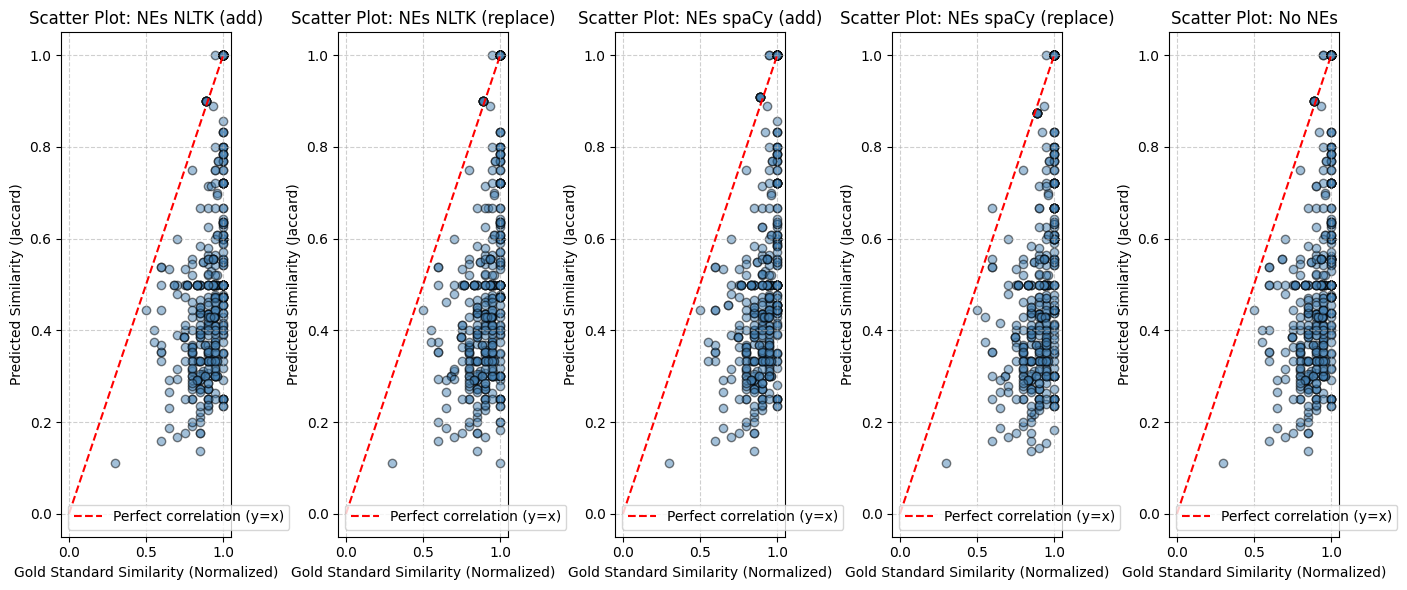

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = (gold_standard_dt[0]/5).values

titles = [
    "NEs NLTK (add)",
    "NEs NLTK (replace)",
    "NEs spaCy (add)",
    "NEs spaCy (replace)",
    "No NEs"
]
ys = [
    similarities_NE_nltk_add,
    similarities_NE_nltk_replace,
    similarities_NE_spaCy_add,
    similarities_NE_spaCy_replace,
    similarities
]

fig, ax_arr = plt.subplots(1, 5, figsize=(14, 6))

for ax, y, title in zip(ax_arr, ys, titles):
    y = np.array(y)
    ax.scatter(x, y, alpha=0.5, color="steelblue", edgecolor="k")
    ax.plot([0, 1], [0, 1], '--', color="red", label="Perfect correlation (y=x)")
    ax.set_xlabel("Gold Standard Similarity (Normalized)")
    ax.set_ylabel("Predicted Similarity (Jaccard)")
    ax.set_title(f"Scatter Plot: {title}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()



# Analysis

## Sentence Similarities using NEs

### Intoduction

In this lab we examine whether using NEs can improve our similarity scores using jaccard distance. NEs are real-world objects in text, like  Persons, Organizations, and Locations.

We implemented both NLTKs version of NEs as well as spaCy's to examine how both models perform and compare them against our baseline of not using NEs at all. We also tried out two different versions of each model. We tried strategies "add" and "replace".

- "add": Adds NEs found to the tokens. So set becomes: {'john', 'smith', 'is', 'working', 'john smith'}
- "replace": Replaces NEs found in place of the tokens. So set becomes: {'john smith', 'is', 'working'}

This was done as we are using jaccard similarity to compute similarities between the sentences. The "add" strategy could be beneficial as partial matches could exist. 

### Results and discussion

Below we analyse the results we obtained:

- Pearson correlattion for NEs nltk (add) 0.4625
- Pearson correlattion for NEs nltk (replace) 0.4518
- Pearson correlattion for NEs spacy (add) 0.4610
- Pearson correlattion for NEs spacy (replace) 0.4517
- Pearson correlattion for baseline 0.4624

We observe that adding NEs does not significantly enhance similarity and some times even degrades it.
Our implementation of NEs using nltk and "add" strategy yielded the highest correlation of 0.4625. Second highest was the baseline which came up to 0.4624. The other methods resulted in lower scores with NEs using spaCy and the "replace" strategy yielding the lowest score of 0.4517. 

One explanation of this result could be the following. Jaccard similarity benefits from partial matches. If the sentence is "The European Union announced ..." and the other is "The European Commusion declared ...", the baseline will split "european" and the other word, resulting in a match on "european" in both sentences. However NEs will result in tokens of "european union" and "european commision" which is not a match and hence lowers similarity even though both concept although not the same are related. This can explain why the "replace" strategy performs even worse than the "add" strategy, as in the "add" strategy we are keeping the split word.

Also we observe that NLTKs implementation performs better than spaCy. This could be explained by the underlying models the two libraries use. spaCy uses a more sophisticated model that identifies entities more accurately. However, because of the jaccard similarity measure this does not work in our favor, since more entity boundaries are recognised, more tokens are merged, which as explained before impacts the similarity score negatively. On the other hand NLTK uses a simpler approach, which might miss some entities, working in our favor in this case.

Comparing the two implemented strategies, "add" and "replace" we observe that "add" consistently outperforms "replace". This happens as "add" partialy mitigates the issue using complete NEs in the jaccard measure as we keep the tokens. However, the problem with the "add" strategy, is that it can increase the jaccard similarity of a set of sentences, when unrelated sentences share the same tokens.

### Conclusion

In conclusion, the use of NEs did not seem to significantly improve the similarity scores in comparison the baseline of tokenized, lowercased sentences and even degraded the performance at most instances. This shows that even though we are adding more information and sophistication in our preprocessing pipeline using NEs, the underlying similarity measurement method does not align with this work. The token overlap we achieve in this dataset, outperforms replacing the tokens with the full NEs as jaccard benefits from the partial lexical overlaps. 

